In [5]:
from andylearn import mnist, KNNneighbor, PCA
import matplotlib.pyplot as plt  
import numpy as np
import scipy.io as sio
import scipy.linalg as slg
import math
import pylab
#%matplotlib inline
#%pylab inline

In [6]:
def LPP(data, k, d, t=40):
    '''
    data is the original data. m*n(m=samples, n=dimensions)
    '''
    data = np.matrix(data)
    N = data.shape[0]
    Dim = data.shape[1]
    
    # step 1
    # find the nearest neighbors (k). Here we get the distance from (x-y)^2
    # distance N*N
   
    data_tmp = np.sum(np.multiply(data, data), axis=1)
    distance=np.mat(data_tmp + data_tmp.T - 2*data*data.T)
    sort_index = np.argsort(distance,axis=1)
    # k nearest neibors
    neibors = sort_index[:,1:k+1]
    
    # step 2
    # weights
    
    W=np.zeros([N,N])
    D=np.zeros([N,N])
    for i in range(N):
        for j in neibors[i].A[0]:
            W[i, j] = math.exp(-distance[i, j]/t)
            W[j, i] = W[i, j]
    
    for i in range(N):
        for j in range(N):
            D[i, i] = W[i, j]
    
    # Step 3
    # mappings 
    
    L=D-W
    D_ = np.dot(np.dot(data.T, D), data)
    D_ = D_ + 0.000000001 * np.eye(Dim)
    L_ = np.dot(np.dot(data.T, L), data)
    eigenValues, eigenVectors=np.linalg.eig(np.dot(D_.I, L_))
    eigenValuesIndex = np.argsort(eigenValues)
    mapping = eigenVectors[:, eigenValuesIndex[0:d]]
    
    return mapping

In [7]:
def TwoD_LPP(data, k, n_1, n_2, l_1, l_2, repeatNum, t=40):
    '''
    data is the original data. m*n(m=samples, n=dimensions)
    '''
    data = np.matrix(data)
    N = data.shape[0]
    Dim = data.shape[1]
    
    # step 1
    # find the nearest neighbors (k). Here we get the distance from (x-y)^2
    # distance N*N
   
    data_tmp = np.sum(np.multiply(data, data), axis=1)
    distance=np.mat(data_tmp + data_tmp.T - 2*data*data.T)
    sort_index = np.argsort(distance,axis=1)
    # k nearest neibors
    neibors = sort_index[:,1:k+1]
    
    # step 2
    # weights
    
    W=np.zeros([N,N])
    D=np.zeros([N,N])
    for i in range(N):
        for j in neibors[i].A[0]:
            W[i, j] = math.exp(-distance[i, j]/t)
            W[j, i] = W[i, j]  
   
    
    # Step 3
    # mappings 
    
    # initial L
    L = np.ones((n_1, l_1))
    
    for count in range(repeatNum):
        for i in range(N):
            A_i = data[i, :].reshape((n_1, n_2))
            for j in range(N):
                A_j = data[j, :].reshape((n_1, n_2))
                R_L = W[i, j]*np.dot(np.dot(np.dot((A_i-A_j).T, L), L.T), (A_i-A_j))
                R_R = np.dot(np.dot(np.dot((A_i-A_j).T, L), L.T), (A_i-A_j))

        eigenValues, eigenVectors=np.linalg.eig(np.dot(R_R.I, R_L))
        eigenValuesSort=np.argsort(eigenValues)
        R=np.mat(eigenVectors[:,eigenValuesSort[0:l_2]])

        for i in range(N):
            A_i = data[i, :].reshape((n_1, n_2))
            for j in range(N):
                A_j = data[j, :].reshape((n_1, n_2))
                L_L = W[i, j]*np.dot(np.dot(np.dot((A_i-A_j).T, L), L.T), (A_i-A_j))
                L_R = np.dot(np.dot(np.dot((A_i-A_j).T, L), L.T), (A_i-A_j))

        eigenValues, eigenVectors=np.linalg.eig(np.dot(L_R.I, L_L))
        eigenValuesSort=np.argsort(eigenValues)
        L=np.mat(eigenVectors[:,eigenValuesSort[0:l_1]])
    
    return L, R

In [8]:
def Kernel_LPP(data, k, d, t=40):
    '''
    data is the original data. m*n(m=samples, n=dimensions)
    '''
    data = np.matrix(data)
    N = data.shape[0]
    Dim = data.shape[1]
    
    # step 1
    # find the nearest neighbors (k). Here we get the distance from (x-y)^2
    # distance N*N
   
    data_tmp = np.sum(np.multiply(data, data), axis=1)
    distance=np.mat(data_tmp + data_tmp.T - 2*data*data.T)
    sort_index = np.argsort(distance,axis=1)
    # k nearest neibors
    neibors = sort_index[:,1:k+1]
    
    # step 2
    # weights
    
    W=np.zeros([N,N])
    D=np.zeros([N,N])
    for i in range(N):
        for j in neibors[i].A[0]:
            W[i, j] = math.exp(-distance[i, j]/t)
            W[j, i] = W[i, j]  
    for i in range(N):
        for j in neibors[i].A[0]:
            D[i, i] +=W[i, j]  
    
    # Step 3
    # mappings 
    K=np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            K[i, j] = math.exp(-distance[i, j]/t)
    
    
    L=D-W
    ei_L=np.dot(np.dot(K, L), K)
    ei_R=np.dot(np.dot(K, D), K)
    eigenValues, eigenVectors=np.linalg.eig(np.dot(ei_R.I, ei_L))
    eigenValuesSort=np.argsort(eigenValues)
    mapping = eigenVectors[:, eigenValuesSort[0:d]]
    
    return mapping, K

In [9]:
data=sio.loadmat("data/orl_faces/32_32/ORL_32x32.mat")
face = data['fea']/256
label = data['gnd']

/home/huangzhenyu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


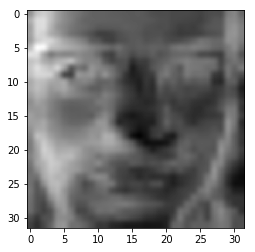

In [10]:
def LPP_faces():
    matfn = 'data/orl_faces/32_32/4Train/1.mat'
    index = sio.loadmat(matfn)
    testIdx = index['testIdx'] -1    
    trainIdx = index['trainIdx'] -1  
    trainface = face[trainIdx]
    mapping = LPP(trainface, 7, 8)
    tmp=mapping.T[1]
    tmp=tmp.reshape(32, 32).astype(float)
    pylab.imshow(tmp.T, cmap='gray', interpolation='hamming')
    pylab.show()
    
LPP_faces()

/home/huangzhenyu/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:583: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


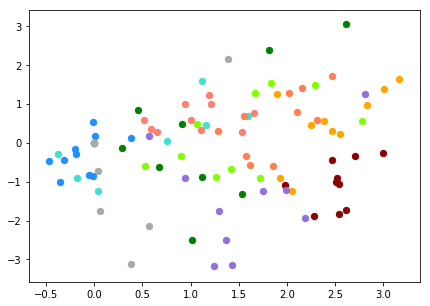

In [12]:
def LPP_ORL_scatters():
    # the first 100 samples
    face100 = np.squeeze(face[:100])
    label100 = np.squeeze(label[:100])
    mapping = LPP(face100, 7, 2)
    low_data = np.dot(face100, mapping)
    
    fig = plt.figure(figsize=(7,5))
    plotwindow = fig.add_subplot(111)
    a = np.array(low_data)

    # draw the scatters
    color = ['green','dodgerblue','chartreuse','turquoise','orange','coral','salmon','darkgray','darkred','mediumpurple']
    for j in range(len(low_data)):
        plt.scatter(a[j][0], a[j][1],s=40, c=color[label100[j]-1])
    plt.show()
LPP_ORL_scatters()

In [14]:
def LaplacianFaces(data, k, d):
    mapping_pca, data_pca, average = PCA.PCA(data, 98)
    mapping_lpp = LPP(data_pca, k, d)
    return np.dot(mapping_pca, mapping_lpp)

/home/huangzhenyu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
/home/huangzhenyu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


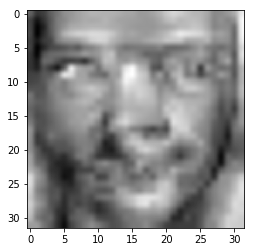

In [16]:
def LP_faces():
    matfn = 'data/orl_faces/32_32/3Train/2.mat'
    index = sio.loadmat(matfn)
    testIdx = index['testIdx'] -1    
    trainIdx = index['trainIdx'] -1  
    trainface = face[trainIdx]
    mapping = LaplacianFaces(trainface, 5, 8)
    tmp=mapping.T[1]
    tmp=tmp.reshape(32, 32).astype(float)
    pylab.imshow(tmp.T, cmap='gray', interpolation='hamming')
    pylab.show()
    
LP_faces()

In [18]:
def LPP_ORL_acuracy(l, method='' ):
    ## 32 * 32 ORL_faces 
    s=0.0
    for i in range(50):
        matfn = 'data/orl_faces/32_32/'+str(l)+'Train/'+str(i+1)+'.mat'
        index = sio.loadmat(matfn)
        testIdx = index['testIdx'] -1  
        trainIdx = index['trainIdx'] -1
        
        if(method =='LPP'):
            #LPP      
            trainface = np.squeeze(face[trainIdx])
            trainlabel = np.squeeze(label[trainIdx])
            testface = np.squeeze(face[testIdx])
            testlabel = np.squeeze(label[testIdx]) 
            mapping = LPP(trainface, 5, 39)
            traindata = np.dot(trainface, mapping)
            testdata = np.dot(testface, mapping)
            tmp=KNNneighbor.accuracy(traindata, trainlabel, testdata, testlabel, 1)
            
        elif(method == '2D LPP'):
            # 2D LPP
            mapping, face_pca, average = PCA.PCA(np.squeeze(face), 225)
            trainface = np.squeeze(face_pca[trainIdx])
            trainlabel = np.squeeze(label[trainIdx])
            testface = np.squeeze(face_pca[testIdx])
            testlabel = np.squeeze(label[testIdx])
            L, R= TwoD_LPP(trainface, 2, 15, 15, 7, 7)

            traindata = []
            testdata = []
            for i in range(trainface.shape[0]):
                traindata.append(np.dot(np.dot(L.T, trainface[i].reshape(15, 15)), R).A[0])
            for i in range(testface.shape[0]):
                testdata.append(np.dot(np.dot(L.T, testface[i].reshape(15, 15)), R).A[0])

            tmp=KNNneighbor.accuracy(traindata, trainlabel, testdata, testlabel, 1)
            
        elif(method == 'Kernel LPP'):
            # kernel
            trainface = np.squeeze(face[trainIdx])
            trainlabel = np.squeeze(label[trainIdx])
            testface = np.squeeze(face[testIdx])
            testlabel = np.squeeze(label[testIdx])

            mapping, K_train= Kernel_LPP(trainface, 10, 55)

            K_test = np.zeros((trainface.shape[0], testface.shape[0]))
            for i in range(trainface.shape[0]):
                for j in range(testface.shape[0]):
                    K_test[i, j]=math.exp(-(np.linalg.norm(trainface[i]-testface[j],ord=2))/2)

            traindata = np.dot(mapping.T, K_train)
            testdata = np.dot(mapping.T, K_test)
            tmp=KNNneighbor.accuracy(traindata.T, trainlabel, testdata.T, testlabel, 1)
        
        #print(tmp)
        s+=tmp
    return s/50

print("s", LPP_ORL_acuracy(6, 'LPP'))

/home/huangzhenyu/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/huangzhenyu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


0.85625
0.875
0.86875
0.925
0.875
0.875
0.84375
0.93125
0.89375
0.85625
0.875
0.88125
0.88125
0.89375
0.8375
0.9125
0.8625
0.8875
0.85625
0.86875
0.85
0.9
0.8875
0.81875
0.8875
0.84375
0.9125
0.875
0.85625
0.875
0.83125
0.8625
0.86875
0.875
0.85625
0.88125
0.89375
0.875
0.81875
0.9
0.8375
0.89375
0.8875
0.85625
0.88125
0.85
0.88125
0.85625
0.85
0.85
0.871375
